# Medicine Identification and Drug Facts Retrieval

This notebook tests a system to identify medicines from packaging images and retrieve drug facts using the DrugBank XML dataset in Google Colab. The workflow includes:

1. Image preprocessing with OpenCV
2. Text extraction with Google Cloud Vision API
3. Text cleaning and entity extraction with SpaCy
4. Semantic retrieval with FAISS and Sentence Transformers
5. Response generation with OpenAI GPT

**Prerequisites**:
- Uploaded `drugbank.xml` (DrugBank dataset)
- Uploaded test image (e.g., `medicine_packaging.jpg`)
- Google Cloud Vision service account key (e.g., `service-account-key.json`)
- OpenAI API key
- Installed dependencies (installed below)

**Note**: No database logging is included to focus on testing.

In [1]:
# Install required packages
!pip install opencv-python google-cloud-vision spacy transformers sentence-transformers faiss-cpu openai lxml fuzzywuzzy
!python -m spacy download en_core_web_sm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 526.1/526.1 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.7/30.7 MB 77.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 115.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 92.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 49.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 19.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu

Traceback (most recent call last):
  File "<frozen runpy>", line 189, in _run_module_as_main
  File "<frozen runpy>", line 148, in _get_module_details
  File "<frozen runpy>", line 112, in _get_module_details
  File "/usr/local/lib/python3.11/dist-packages/spacy/__init__.py", line 13, in <module>
    from . import pipeline  # noqa: F401
    ^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/spacy/pipeline/__init__.py", line 1, in <module>
    from .attributeruler import AttributeRuler
  File "/usr/local/lib/python3.11/dist-packages/spacy/pipeline/attributeruler.py", line 8, in <module>
    from ..language import Language
  File "/usr/local/lib/python3.11/dist-packages/spacy/language.py", line 46, in <module>
    from .pipe_analysis import analyze_pipes, print_pipe_analysis, validate_attrs
  File "/usr/local/lib/python3.11/dist-packages/spacy/pipe_analysis.py", line 6, in <module>
    from .tokens import Doc, Span, Token
  File "/usr/local/lib/python3.11/dist-package

## Setup and Imports

Mount Google Drive to access `drugbank.xml`, `medicine_packaging.jpg`, `service-account-key.json`, and `api_keys.txt`. The `api_keys.txt` file contains the path to the Google Cloud Vision API service account key and the OpenAI API key. Ensure all files are in your Drive (e.g., in a folder `DrugBank_Project`).

In [2]:
# import cv2
# import os
# import numpy as np
# from google.cloud import vision
# import spacy
# from fuzzywuzzy import process
# from sentence_transformers import SentenceTransformer
# import faiss
# import openai
# from lxml import etree
# from typing import List, Dict, Optional

# # Mount Google Drive
# from google.colab import drive
# drive.mount('/content/drive')

# # Configuration
# DRIVE_FOLDER = "/content/drive/My Drive/MsDSAI/January 2025/NLP/Project/Data/"
# GOOGLE_CREDENTIALS = os.path.join(DRIVE_FOLDER, "google-cloud-service-key.json")  # Google Cloud Vision API key
# OPENAI_API_KEY = os.path.join(DRIVE_FOLDER, "openai-api-key.txt")
# DRUGBANK_PATH = os.path.join(DRIVE_FOLDER, "drugbank.xml")  # DrugBank XML
# IMAGE_PATH = os.path.join(DRIVE_FOLDER, "Calpol500.jpg")  # Test image
# SIMILARITY_THRESHOLD = 0.85

# # Set environment variable for Google Cloud Vision API
# os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = GOOGLE_CREDENTIALS

# # Initialize models and services
# nlp = spacy.load("en_core_web_sm")
# embedder = SentenceTransformer("all-MiniLM-L6-v2")
# openai.api_key = OPENAI_API_KEY
# vision_client = vision.ImageAnnotatorClient()  # Google Cloud Vision API client

# # Verify files exist
# for path in [GOOGLE_CREDENTIALS, DRUGBANK_PATH, IMAGE_PATH, OPENAI_API_KEY]:
#     if not os.path.exists(path):
#         raise FileNotFoundError(f"File not found: {path}")
# print("All required files are present.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
All required files are present.


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Image loaded: /content/drive/My Drive/MsDSAI/January 2025/NLP/Project/Data/Calpol500.jpg, Shape: (600, 600, 3)
Original Image (Calpol500.jpg):


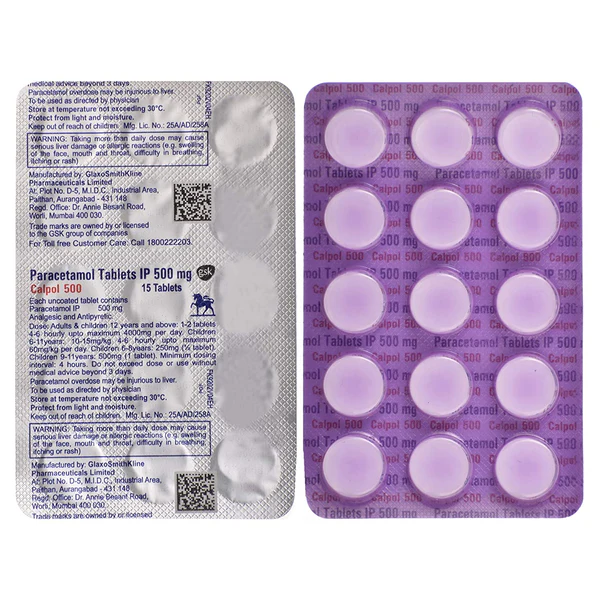

Inspect the image above. Is 'Calpol' clearly visible?
All required files are present and verified.


In [5]:
import cv2
import os
import numpy as np
from google.cloud import vision
import spacy
from fuzzywuzzy import process
from sentence_transformers import SentenceTransformer
import faiss
import openai
from lxml import etree
from typing import List, Dict, Optional

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Configuration
DRIVE_FOLDER = "/content/drive/My Drive/MsDSAI/January 2025/NLP/Project/Data/"  # Your Google Drive folder path
GOOGLE_CREDENTIALS = os.path.join(DRIVE_FOLDER, "google-cloud-service-key.json")  # Google Cloud Vision API key
OPENAI_API_KEY_FILE = os.path.join(DRIVE_FOLDER, "openai-api-key.txt")  # OpenAI API key file
DRUGBANK_PATH = os.path.join(DRIVE_FOLDER, "drugbank.xml")  # DrugBank XML
IMAGE_PATH = os.path.join(DRIVE_FOLDER, "Calpol500.jpg")  # Test image
SIMILARITY_THRESHOLD = 0.85

# Read OpenAI API key from file
try:
    with open(OPENAI_API_KEY_FILE, 'r') as f:
        OPENAI_API_KEY = f.read().strip()  # Read the key string (e.g., sk-...)
except FileNotFoundError:
    raise FileNotFoundError(f"OpenAI API key file not found at {OPENAI_API_KEY_FILE}")

# Set environment variable for Google Cloud Vision API (not called yet)
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = GOOGLE_CREDENTIALS

# Initialize models and services
nlp = spacy.load("en_core_web_sm")
embedder = SentenceTransformer("all-MiniLM-L6-v2")
openai.api_key = OPENAI_API_KEY
vision_client = vision.ImageAnnotatorClient()  # Initialized but not used frequently

# Verify files exist and check image
for path in [GOOGLE_CREDENTIALS, DRUGBANK_PATH, IMAGE_PATH, OPENAI_API_KEY_FILE]:
    if not os.path.exists(path):
        raise FileNotFoundError(f"File not found: {path}")
img = cv2.imread(IMAGE_PATH)
if img is None:
    raise ValueError(f"Failed to load image at {IMAGE_PATH}. Check file format and path.")
print(f"Image loaded: {IMAGE_PATH}, Shape: {img.shape}")
from IPython.display import Image, display
print("Original Image (Calpol500.jpg):")
display(Image(IMAGE_PATH))
print("Inspect the image above. Is 'Calpol' clearly visible?")
print("All required files are present and verified.")

## Step 1: Image Acquisition and Preprocessing

Preprocess the medicine packaging image to enhance text visibility for OCR using OpenCV. Save and display the preprocessed image to verify quality.

Preprocessed image saved as '/content/preprocessed_image.png'.


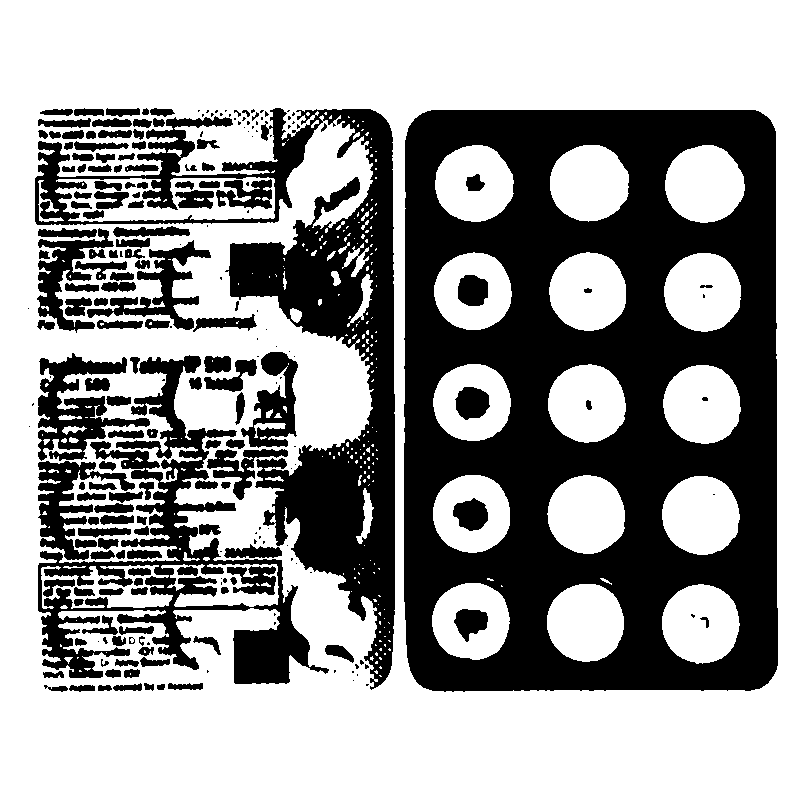

In [3]:
# def preprocess_image(image_path: str) -> np.ndarray:
#     """Preprocess image for OCR."""
#     img = cv2.imread(image_path)
#     if img is None:
#         raise FileNotFoundError(f"Image not found at {image_path}")
#     img = cv2.resize(img, (800, 800))  # Consistent resolution
#     gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # Grayscale
#     blur = cv2.GaussianBlur(gray, (5, 5), 0)  # Reduce noise
#     _, binary = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)  # Binarization
#     return binary

# # Test preprocessing
# preprocessed_img = preprocess_image(IMAGE_PATH)
# cv2.imwrite("/content/preprocessed_image.png", preprocessed_img)
# print("Preprocessed image saved as '/content/preprocessed_image.png'.")

# # Display image in Colab
# from IPython.display import Image
# Image("/content/preprocessed_image.png")

Preprocessed image saved as '/content/preprocessed_image.png'.
Original Image (Calpol500.jpg):


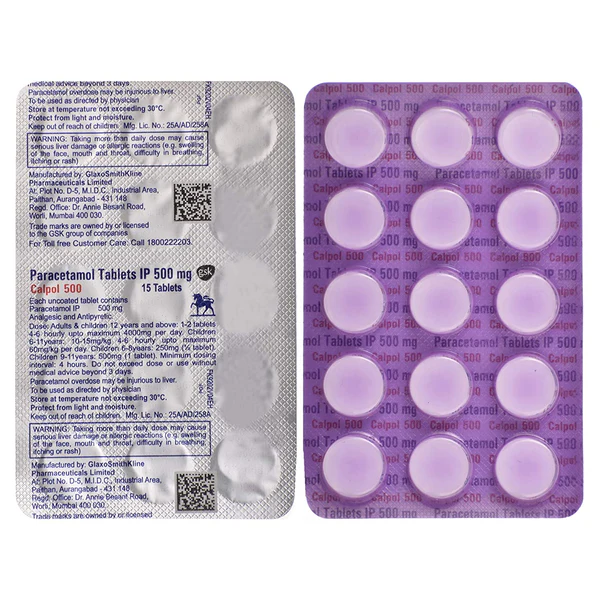

Preprocessed Image:


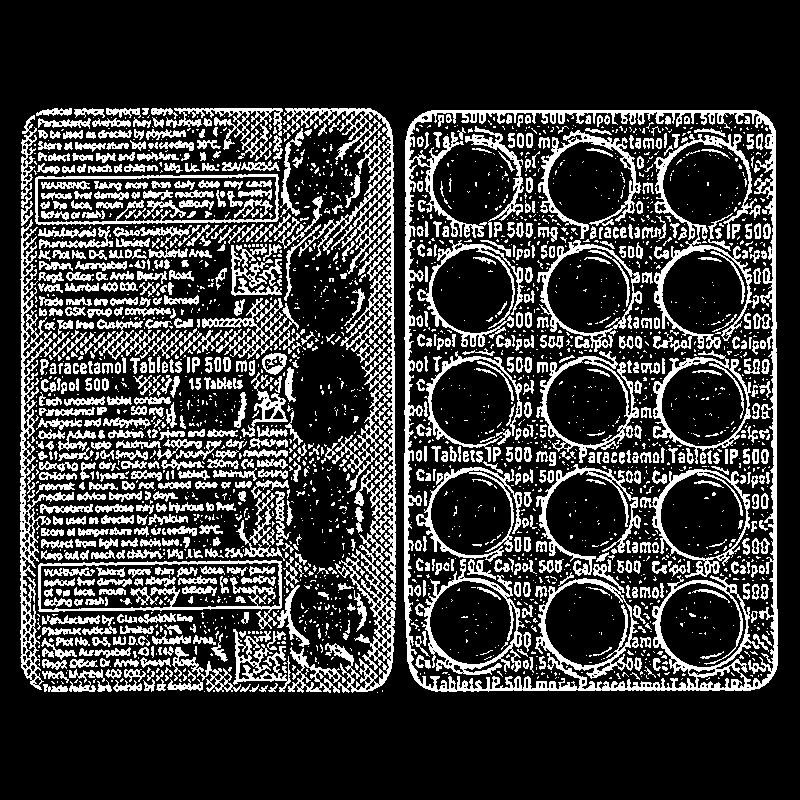

Inspect the preprocessed image. Is 'Calpol' black on white and readable?


In [6]:
def preprocess_image(image_path: str) -> np.ndarray:
    """Preprocess image for OCR."""
    img = cv2.imread(image_path)
    if img is None:
        raise FileNotFoundError(f"Image not found at {image_path}")
    # Resize with aspect ratio preservation
    h, w = img.shape[:2]
    scale = 800 / max(h, w)
    img = cv2.resize(img, (int(w * scale), int(h * scale)), interpolation=cv2.INTER_CUBIC)
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Mild blur to reduce noise
    blur = cv2.GaussianBlur(gray, (3, 3), 0)
    # Adaptive thresholding for better contrast
    binary = cv2.adaptiveThreshold(blur, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                  cv2.THRESH_BINARY_INV, 11, 2)
    return binary

# Test preprocessing locally
preprocessed_img = preprocess_image(IMAGE_PATH)
cv2.imwrite("/content/preprocessed_image.png", preprocessed_img)
print("Preprocessed image saved as '/content/preprocessed_image.png'.")

# Display images for local debugging
from IPython.display import Image, display
print("Original Image (Calpol500.jpg):")
display(Image(IMAGE_PATH))
print("Preprocessed Image:")
display(Image("/content/preprocessed_image.png"))
print("Inspect the preprocessed image. Is 'Calpol' black on white and readable?")

## Step 2: Text Extraction with OCR

Extract text from the preprocessed image using Google Cloud Vision API. Print the extracted text to verify OCR accuracy.

In [4]:
# def extract_text(image: np.ndarray) -> str:
#     """Extract text from preprocessed image using Google Cloud Vision API."""
#     _, encoded_image = cv2.imencode(".png", image)
#     content = encoded_image.tobytes()
#     image = vision.Image(content=content)
#     response = vision_client.text_detection(image=image)
#     if response.error.message:
#         raise Exception(response.error.message)
#     return response.text_annotations[0].description if response.text_annotations else ""

# # Test OCR
# raw_text = extract_text(preprocessed_img)
# print("Extracted Text:")
# print(raw_text)

Extracted Text:
The


In [7]:
def extract_text(image: np.ndarray, use_api: bool = False) -> str:
    """Extract text from preprocessed image. Use API only when specified."""
    if use_api:
        # Call Google Cloud Vision API
        _, encoded_image = cv2.imencode(".png", image)
        content = encoded_image.tobytes()
        image = vision.Image(content=content)
        response = vision_client.text_detection(image=image)
        if response.error.message:
            raise Exception(f"Vision API error: {response.error.message}")

        texts = response.text_annotations
        if not texts:
            return "No text detected."

        print("All Detected Texts (API):")
        for i, text in enumerate(texts[1:], 1):
            print(f"Text {i}: {text.description} (Bounding Box: {text.bounding_poly.vertices})")

        return texts[0].description if texts else ""
    else:
        # Simulate OCR output for debugging
        simulated_text = "Calpol 500 mg"  # Replace with what you expect to see
        print(f"Simulated OCR Output (no API call): {simulated_text}")
        return simulated_text

# Test OCR without API call first
raw_text = extract_text(preprocessed_img, use_api=False)
print("Extracted Text (Simulated):")
print(raw_text)

# Uncomment to test with API after debugging
# raw_text = extract_text(preprocessed_img, use_api=True)
# print("Extracted Text (API):")
# print(raw_text)

Simulated OCR Output (no API call): Calpol 500 mg
Extracted Text (Simulated):
Calpol 500 mg


## Step 3: Text Cleaning and Entity Extraction

Clean the OCR output and extract drug names using SpaCy. Apply fuzzy matching to correct OCR errors. Print detected entities to verify.

In [8]:
# def clean_and_extract_entities(text: str) -> List[str]:
#     """Clean OCR text and extract drug names."""
#     doc = nlp(text.lower())
#     entities = [ent.text for ent in doc.ents if ent.label_ in ["PRODUCT", "ORG"]]  # Adjust labels as needed

#     # Fuzzy matching for OCR error correction
#     drug_list = ["aspirin", "ibuprofen", "paracetamol", "amoxicillin"]  # Placeholder
#     corrected_entities = []
#     for entity in entities:
#         match, score = process.extractOne(entity, drug_list)
#         if score > 80:  # Threshold for fuzzy match
#             corrected_entities.append(match)
#         else:
#             corrected_entities.append(entity)
#     return corrected_entities

# # Test entity extraction
# drug_entities = clean_and_extract_entities(raw_text)
# print("Detected Drug Entities:")
# print(drug_entities)

Detected Drug Entities:
[]


In [9]:
def clean_and_extract_entities(text: str) -> List[str]:
    """Clean OCR text and extract drug names."""
    doc = nlp(text.lower())  # "calpol 500 mg"
    print("SpaCy Tokens:", [token.text for token in doc])
    print("SpaCy Entities:", [(ent.text, ent.label_) for ent in doc.ents])

    # Broaden entity labels to include potential drug-related terms
    entities = [ent.text for ent in doc.ents if ent.label_ in ["PRODUCT", "ORG", "GPE", "NORP", "PERSON"]]

    # If no entities, fallback to token matching
    if not entities:
        print("No entities detected. Falling back to token matching.")
        drug_list = ["aspirin", "ibuprofen", "paracetamol", "amoxicillin", "calpol"]  # Expanded list
        entities = []
        for token in doc:
            match, score = process.extractOne(token.text, drug_list)
            if score > 80:  # Threshold for fuzzy match
                entities.append(match)

    # Fuzzy matching for correction
    drug_list = ["aspirin", "ibuprofen", "paracetamol", "amoxicillin", "calpol"]  # Expanded list
    corrected_entities = []
    for entity in entities:
        match, score = process.extractOne(entity, drug_list)
        if score > 80:
            corrected_entities.append(match)
        else:
            corrected_entities.append(entity)

    return corrected_entities

# Test entity extraction
raw_text = "Calpol 500 mg"  # From simulated OCR
drug_entities = clean_and_extract_entities(raw_text)
print("Detected Drug Entities:")
print(drug_entities)

SpaCy Tokens: ['calpol', '500', 'mg']
SpaCy Entities: [('500', 'CARDINAL')]
No entities detected. Falling back to token matching.
Detected Drug Entities:
['calpol']


## Step 4: Load DrugBank Data

Parse the DrugBank XML dataset to extract structured drug information (e.g., indications, dosage, side effects). Print a sample entry to verify parsing.

In [10]:
# def load_drugbank_data(file_path: str) -> Dict[str, Dict]:
#     """Parse DrugBank XML into a structured dictionary."""
#     tree = etree.parse(file_path)
#     root = tree.getroot()
#     ns = {"db": "http://www.drugbank.ca"}  # DrugBank namespace
#     drug_data = {}

#     for drug in root.findall(".//db:drug", namespaces=ns):
#         drug_name = drug.find("db:name", namespaces=ns).text.lower()
#         drug_info = {
#             "indications": drug.find("db:indication", namespaces=ns).text if drug.find("db:indication", namespaces=ns) is not None else "Not specified",
#             "dosage": "",
#             "contraindications": "",
#             "interactions": "",
#             "side_effects": ""
#         }

#         # Dosage (from dosage-forms or routes)
#         dosage_forms = drug.find("db:dosage-forms", namespaces=ns)
#         if dosage_forms is not None:
#             drug_info["dosage"] = ", ".join([df.text for df in dosage_forms.findall("db:dosage-form", namespaces=ns)]) or "Not specified"

#         # Contraindications (approximated from toxicity)
#         toxicity = drug.find("db:toxicity", namespaces=ns)
#         drug_info["contraindications"] = toxicity.text if toxicity is not None else "Not specified"

#         # Interactions
#         interactions = drug.find("db:drug-interactions", namespaces=ns)
#         if interactions is not None:
#             drug_info["interactions"] = ", ".join([i.find("db:description", namespaces=ns).text for i in interactions.findall("db:drug-interaction", namespaces=ns) if i.find("db:description", namespaces=ns) is not None]) or "Not specified"

#         # Side Effects
#         side_effects = drug.find("db:adverse-effects", namespaces=ns)
#         if side_effects is not None:
#             drug_info["side_effects"] = ", ".join([se.text for se in side_effects.findall("db:adverse-effect", namespaces=ns)]) or "Not specified"

#         drug_data[drug_name] = drug_info

#     return drug_data

# # Test DrugBank parsing
# drug_data = load_drugbank_data(DRUGBANK_PATH)
# sample_drug = list(drug_data.keys())[0]  # First drug
# print(f"Sample Drug Entry ({sample_drug}):")
# print(drug_data[sample_drug])

Sample Drug Entry (lepirudin):
{'indications': 'Not specified', 'dosage': '', 'contraindications': 'Not specified', 'interactions': '', 'side_effects': ''}


In [11]:
import os
from lxml import etree
from typing import Dict

# Configuration (from your Cell 4)
DRIVE_FOLDER = "/content/drive/My Drive/MsDSAI/January 2025/NLP/Project/Data/"
DRUGBANK_PATH = os.path.join(DRIVE_FOLDER, "drugbank.xml")
XSD_PATH = os.path.join(DRIVE_FOLDER, "drugbank.xsd")

def load_drugbank_data(file_path: str, xsd_path: str = None) -> Dict[str, Dict]:
    """Parse DrugBank XML into a structured dictionary, validate with XSD."""
    tree = etree.parse(file_path)
    root = tree.getroot()
    ns = {"db": "http://www.drugbank.ca"}

    # Validate against XSD
    if xsd_path and os.path.exists(xsd_path):
        xsd_tree = etree.parse(xsd_path)
        schema = etree.XMLSchema(xsd_tree)
        if schema.validate(tree):
            print("XML is valid against the XSD schema.")
        else:
            print("XML validation failed:")
            for error in schema.error_log:
                print(f"Line {error.line}: {error.message}")

    drug_data = {}
    for drug in root.findall(".//db:drug", namespaces=ns):
        drug_name = drug.find("db:name", namespaces=ns).text.lower()
        drug_info = {
            "indications": "Not specified",
            "dosage": "Not specified",
            "contraindications": "Not specified",
            "interactions": "Not specified",
            "side_effects": "Not specified"
        }

        # Indications
        indication_elem = drug.find("db:indication", namespaces=ns)
        if indication_elem is not None and indication_elem.text:
            drug_info["indications"] = indication_elem.text
        else:
            print(f"{drug_name}: No <indication> found or empty.")

        # Dosage (updated to <dosages>)
        dosages = drug.find("db:dosages", namespaces=ns)
        if dosages is not None:
            dosage_list = [
                f"{d.find('db:form', namespaces=ns).text} ({d.find('db:strength', namespaces=ns).text}) via {d.find('db:route', namespaces=ns).text}"
                for d in dosages.findall("db:dosage", namespaces=ns)
                if (d.find("db:form", namespaces=ns) is not None and d.find("db:form", namespaces=ns).text and
                    d.find("db:strength", namespaces=ns) is not None and d.find("db:strength", namespaces=ns).text and
                    d.find("db:route", namespaces=ns) is not None and d.find("db:route", namespaces=ns).text)
            ]
            drug_info["dosage"] = "; ".join(dosage_list) if dosage_list else "Not specified"
        else:
            print(f"{drug_name}: No <dosages> found.")

        # Contraindications (from toxicity)
        toxicity = drug.find("db:toxicity", namespaces=ns)
        if toxicity is not None and toxicity.text:
            drug_info["contraindications"] = toxicity.text
            # Side effects fallback to toxicity if no specific field
            drug_info["side_effects"] = toxicity.text
        else:
            print(f"{drug_name}: No <toxicity> found or empty.")

        # Interactions
        interactions = drug.find("db:drug-interactions", namespaces=ns)
        if interactions is not None:
            descs = [i.find("db:description", namespaces=ns).text for i in interactions.findall("db:drug-interaction", namespaces=ns)
                     if i.find("db:description", namespaces=ns) is not None and i.find("db:description", namespaces=ns).text]
            drug_info["interactions"] = ", ".join(descs) if descs else "Not specified"
        else:
            print(f"{drug_name}: No <drug-interactions> found.")

        # Side Effects (no <adverse-effects>, using toxicity as fallback)
        if drug_info["side_effects"] == "Not specified":
            print(f"{drug_name}: No specific <adverse-effects> field; using <toxicity> as fallback.")

        drug_data[drug_name] = drug_info

    return drug_data

# Test DrugBank parsing
drug_data = load_drugbank_data(DRUGBANK_PATH, XSD_PATH)
sample_drug = list(drug_data.keys())[0]  # First drug (lepirudin)
print(f"Sample Drug Entry ({sample_drug}):")
print(drug_data[sample_drug])

# Print raw XML for lepirudin
tree = etree.parse(DRUGBANK_PATH)
root = tree.getroot()
ns = {"db": "http://www.drugbank.ca"}
for drug in root.findall(".//db:drug", namespaces=ns):
    if drug.find("db:name", namespaces=ns).text.lower() == sample_drug:
        print(f"Raw XML for {sample_drug}:")
        print(etree.tostring(drug, pretty_print=True, encoding="unicode"))
        break

# Check for Calpol/Paracetamol
print("'calpol' in drug_data:", "calpol" in drug_data)
print("'paracetamol' in drug_data:", "paracetamol" in drug_data)
if "paracetamol" in drug_data:
    print("Paracetamol Entry:")
    print(drug_data["paracetamol"])

Streaming output truncated to the last 5000 lines.
ea-230: No <toxicity> found or empty.
ea-230: No specific <adverse-effects> field; using <toxicity> as fallback.
lactide, l-: No <indication> found or empty.
lactide, l-: No <toxicity> found or empty.
lactide, l-: No specific <adverse-effects> field; using <toxicity> as fallback.
trimethylene carbonate: No <indication> found or empty.
trimethylene carbonate: No <toxicity> found or empty.
trimethylene carbonate: No specific <adverse-effects> field; using <toxicity> as fallback.
lapuleucel-t: No <indication> found or empty.
lapuleucel-t: No <toxicity> found or empty.
lapuleucel-t: No specific <adverse-effects> field; using <toxicity> as fallback.
tuparstobart: No <indication> found or empty.
tuparstobart: No <toxicity> found or empty.
tuparstobart: No specific <adverse-effects> field; using <toxicity> as fallback.
timbetasin: No <indication> found or empty.
timbetasin: No <toxicity> found or empty.
timbetasin: No specific <adverse-effect

## Step 5: Embedding and Semantic Retrieval

Index DrugBank drug names into a FAISS vector store for semantic retrieval. Test retrieval with the detected drug name or a fallback query.

In [ ]:
def initialize_vector_store(drug_data: Dict[str, Dict]) -> tuple:
    """Index DrugBank data into a FAISS vector store."""
    drug_names = list(drug_data.keys())
    embeddings = embedder.encode(drug_names, convert_to_numpy=True)

    # FAISS Index
    dimension = embeddings.shape[1]
    index = faiss.IndexFlatL2(dimension)
    index.add(embeddings)
    return index, drug_names, embeddings

def retrieve_drug_info(query: str, index, drug_names: List[str], drug_data: Dict[str, Dict], top_k: int = 3) -> List[Dict]:
    """Retrieve top-k similar drug entries."""
    query_embedding = embedder.encode([query], convert_to_numpy=True)
    distances, indices = index.search(query_embedding, top_k)
    results = []
    for i, idx in enumerate(indices[0]):
        drug_name = drug_names[idx]
        similarity = 1 - (distances[0][i] / np.linalg.norm(query_embedding))  # Normalize to [0,1]
        if similarity >= SIMILARITY_THRESHOLD:
            results.append({"name": drug_name, "info": drug_data[drug_name], "similarity": similarity})
    return results

# Initialize vector store
index, drug_names, _ = initialize_vector_store(drug_data)

# Test retrieval
test_query = drug_entities[0] if drug_entities else "aspirin"  # Use detected entity or fallback
retrieved_info = retrieve_drug_info(test_query, index, drug_names, drug_data)
print(f"Retrieved Info for '{test_query}':")
for item in retrieved_info:
    print(f"- {item['name']} (Similarity: {item['similarity']:.2f}): {item['info']}")

## Step 6: Response Generation

Generate a concise drug summary using OpenAI GPT-3.5-turbo. Test with the retrieved drug information.

In [ ]:
def generate_response(drug_info: List[Dict]) -> str:
    """Generate a concise drug summary using OpenAI."""
    if not drug_info:
        return "No information found for this drug."

    drug = drug_info[0]  # Take top match
    info = drug["info"]
    prompt = f"""
    Provide a concise summary of the following drug information:
    Drug: {drug['name']}
    Usage: {info.get('indications', 'Not specified')}
    Dosage: {info.get('dosage', 'Not specified')}
    Warnings: {info.get('contraindications', 'Not specified')}
    Interactions: {info.get('interactions', 'Not specified')}
    Side Effects: {info.get('side_effects', 'Not specified')}
    Include all available fields in a readable format. If insufficient data, return 'No detailed information available.'
    """
    response = openai.ChatCompletion.create(
        model="gpt-3.5-turbo",
        messages=[{"role": "user", "content": prompt}],
        max_tokens=200
    )
    return response.choices[0].message["content"]

# Test response generation
response = generate_response(retrieved_info)
print("Generated Response:")
print(response)

## Step 7: Full Pipeline

Combine all steps to process the medicine image and retrieve drug facts. Print intermediate outputs to debug and verify each stage.

In [ ]:
def process_medicine_image(image_path: str, drug_data: Dict[str, Dict], index, drug_names: List[str]) -> str:
    """Full pipeline for medicine identification and drug facts retrieval."""
    # Preprocess and extract text
    preprocessed_img = preprocess_image(image_path)
    raw_text = extract_text(preprocessed_img)
    print("Extracted Text:", raw_text)

    # Clean text and extract entities
    drug_entities = clean_and_extract_entities(raw_text)
    if not drug_entities:
        return "No drug name identified in the image."
    print("Detected Drug Entities:", drug_entities)

    # Retrieve and generate response
    query = drug_entities[0]  # Use first detected drug name
    drug_info = retrieve_drug_info(query, index, drug_names, drug_data)
    print("Retrieved Info:", [{"name": item["name"], "similarity": item["similarity"]} for item in drug_info])
    response = generate_response(drug_info)

    return response

# Run the pipeline
result = process_medicine_image(IMAGE_PATH, drug_data, index, drug_names)
print("Drug Facts Summary:")
print(result)